<a href="https://colab.research.google.com/github/slowandfast/DiagRecommdSystem_01/blob/main/KJH_BERT_EMR%EA%B8%B0%EB%B0%98_%EC%A7%84%EB%8B%A8%EC%B6%94%EC%B2%9C%EB%AA%A8%EB%8D%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch>=1.7.1
!pip install transformers
!pip install torchvision

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
!pip install transformers
import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [ ]:
file_path = '/content/target_df.xlsx'
# file_path = "D:\\sample\\content\\신장내과_본원_외래_20230701_20231231_filtered.xlsx"

# selected_columns = ['ICD10', 'transstr']
selected_columns = ['ICD10', 'CC', 'PI', 'CC_trans', 'PI_trans', 'record']
df = pd.read_excel(file_path, usecols=selected_columns, dtype=str)

df['ICD10'] = df['ICD10'].astype(str)
df['record'] = df['record'].astype(str)

print('전체 데이터 수 :', len(df))
df.head(5)

전체 데이터 수 : 826


,ICD10,CC,PI,CC_trans,PI_trans,record
0,N391,NaN,115-61-61_x000D_\n2023.5.10._x000D_\n_x000D_\n...,NaN,115-61-61 2023.5.10.Protein Protein Protein Pr...,115-61-61 2023.5.10.Protein Protein Protein Pr...
1,N184,"CKD4, Cr 2.26, eGFR 29ml/min","130/61/69_x000D_\n요증상(-), edema(-), 요독증상(-), D...","ckd4, cr 2.26, egfr 29ml/min","130/61/69 There is no symptom, no edema, no dy...","ckd4, cr 2.26, egfr 29ml/min. 130/61/69 There ..."
2,N184,CKD4,"153/75/85_x000D_\n요증상(-), edema(-), 요독증상(-), D...",ckd4,"153/75/85 There is no symptom, no edema, no di...","ckd4. 153/75/85 There is no symptom, no edema,..."
3,N185,"Cr 3.74, eGFR 13.56","148/90/64_x000D_\n요증상(-), edema mild_x000D_\nC...","cr 3.74, egfr 13.56","148/90/64 No symptoms, edema Mild CKD D/T ADPK...","cr 3.74, egfr 13.56. 148/90/64 No symptoms, ed..."
4,N183,lab abnormality,선생님 안녕하십니까_x000D_\n_x000D_\n상기 병명으로 입원하여 치료중인 ...,lab abnormality,I am hospitalized and treated with a disease n...,lab abnormality. I am hospitalized and treated...


In [ ]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

seed_val = 35

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA L4


In [ ]:
df.describe()

,ICD10,CC,PI,CC_trans,PI_trans,record
count,826,749,826,748,826,826
unique,14,214,815,175,816,816
top,N183,azotemia,이전 검진에서 특이소견 들은 적 없다 하심._x000D_\n2022-3. 대구파티마...,azotemia,"The patient is a patient of 84 years old, trea...",azotemia. The patient is a patient of 84 years...
freq,282,94,2,187,2,2


<Axes: >

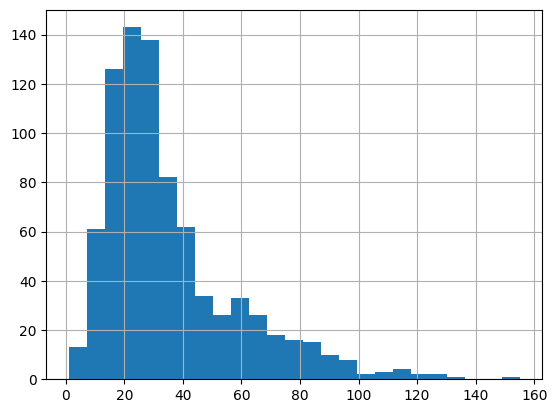

In [ ]:
# get length of all the text in the dataframe
seq_len_premise = [len(i.split()) for i in df['record']]

pd.Series(seq_len_premise).hist(bins = 25)

<Axes: xlabel='count', ylabel='ICD10'>

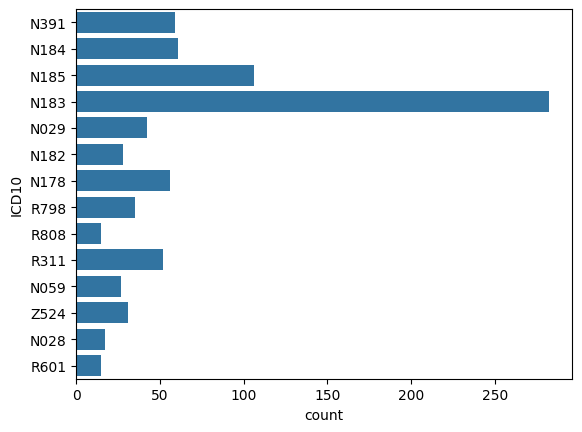

In [ ]:
# Plot the count of fake and true news
sns.countplot(df['ICD10'])

In [ ]:
# stopwords dataset load
# sw_path = "D:\\sample\\content2\\stopwords.xlsx"
sw_path = "/content/stopwords.xlsx"
sw_df = pd.read_excel(sw_path)
for i in range(len(sw_df)) :
  stop_words = sw_df['stop words'].tolist()
# print(stop_words)

In [ ]:
# Remove english stopwords
df['record'] = df['record'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
#  Preprocess train dataset
# remove special characters from text column
df.record = df.record.str.replace('[#,@,&]', '')
# Remove digits
df.record = df.record.str.replace('\d*','')
#Remove www
df.record = df.record.str.replace('w{3}','')
# remove urls
df.record = df.record.str.replace("http\S+", "")
# remove multiple spaces with single space
df.record = df.record.str.replace('\s+', ' ')
#remove all single characters
df.record = df.record.str.replace(r'\s+[a-zA-Z]\s+', '')
# 여러번 반복되는 문자 하나만 표현
df.record = df.record.str.replace('=+', ' ')

In [ ]:
# 학습용, 테스트용, 검증용 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(df['record'], df['ICD10'], test_size=0.3, shuffle=True, random_state=52, stratify=df['ICD10'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=73, stratify=y_temp)

# X_train, X_temp, y_train, y_temp = train_test_split(df['record'], df['ICD10'], test_size=0.2, random_state=None, stratify=df['ICD10'])
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(X_train)
print("=======================================\n")
print(X_test)
print("=======================================\n")
print(X_val)
print("=======================================\n")
print(y_train)
print("=======================================\n")
print(y_test)
print("=======================================\n")
print(y_val)

431    azotemia. The patient is a patient 84 years ol...
263    azotemia. I have never checked it before 2023....
786    azotemia. Four years ago, HTN was confirmed in...
331    hematuria. Hematuria Clot occurred from HTN, D...
760    proteinuria. No HTN, no DM No MDS F/U In the t...
                             ...                        
258    112-56-78 Vomiting pruritus vomiting vsd Close...
58     hematuria. Hematuria is heard from the 20s 30s...
518    hematuria. 2023. Listen to hematuria.Gross Hem...
417    2016년 cr 1.9, 2023.6 cr 1.6mg/dl. 139/88/88 No...
163                                            121-65-91
Name: record, Length: 578, dtype: object

161    proteinuria. OLD ICH, RT BG HTN (I knew it bef...
30     for evaluation persistent proteinuria. From ar...
20     116-72-67 Hypertension 4-year Gallens Cypse Pi...
766    130-84-103 dm dm retinopathy (avastin laser) 2...
39     Reminery decrease. 2017. CR 0.89 EGFR 85 U/A P...
                             ...              

In [ ]:
# Categorical encoding
from sklearn.preprocessing import OneHotEncoder

label_dict = df['ICD10'].unique()
print("labels :", label_dict)
category = label_dict.reshape(-1, 1)

# label one-hot-encoding
onehot_encoder = OneHotEncoder() #sparse_output=False

# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다
y_train_encoded = onehot_encoder.fit_transform(pd.DataFrame(y_train)[['ICD10']])
y_test_encoded = onehot_encoder.transform(pd.DataFrame(y_test)[['ICD10']])
y_val_encoded = onehot_encoder.transform(pd.DataFrame(y_val)[['ICD10']])

# print(y_train_encoded.toarray())

y_train_dense = y_train_encoded.todense()
y_test_dense = y_test_encoded.todense()
y_val_dense = y_val_encoded.todense()

labels : ['N391' 'N184' 'N185' 'N183' 'N029' 'N182' 'N178' 'R798' 'R808' 'R311'
 'N059' 'Z524' 'N028' 'R601']


In [ ]:
model_name = 'emilyalsentzer/Bio_ClinicalBERT'

#tokenizer = transformers.BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)
#bert_model = transformers.BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

SEQ_LEN = 128
batch_size = 2
epochs = 2
learning_rate = 1e-3 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 1
num_workers = 1

In [ ]:
def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train]
split_test_text = [get_split(t) for t in X_test]
split_val_text = [get_split(t) for t in X_val]

In [ ]:
# split_val_text

["['will know. 135/98-125 Brain Lion Lion Training Inner Inner Inn 2023 10 13 ESRD D/T DMN HD START Current Catholic Union Medical Union HD is HD.Dialysis BW GAIN 1-1.5 kg, 78.5 Residual Urine Vol 200-500 ml/Day Kidney Transplantation HX Urine, Arrhythmia condition is okay']",
 "['cr 1.89, ckd management. 133/78/82 There is no symptom, no edema, no diagram, no doe dm (> 15YRS), htn (7YRS), CKD (> 7YRS) patients ancient cancer.LMC inspection CR 1.89, Prot 2+, HB 8.7']",
 "['Proteinuria, hematuria. 2023. For the first time in the examination, proteinuria 2023-11-1 U/3+ OB 3+ R/W Many/6-10 serum CR 0.93 Milk Seat 3 months.']",
 "['hematuria. Hematuria lasted last year, so there is also incontinence bp 123/77/63']",
 "['hematuria. 2022.11.08 There was no hematuria when ER visits.']",
 "['for kidney donation. I have been receiving it to donate kidney donation, but the result is still high for one -year fasting blood sugar, BP 128/84/79']",
 "['isolated hematuria since 2023.6. 106/79/104 No 

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(model_name, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_val_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
trencoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
#compute the class weights
class_wts = compute_class_weight(classes=np.unique(df['ICD10'].values.tolist()), y=df['ICD10'], class_weight='balanced')

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [ ]:
y_train

431    N183
263    N178
786    N183
331    N029
760    R808
       ... 
258    N182
58     N029
518    N029
417    N183
163    Z524
Name: ICD10, Length: 578, dtype: object

In [ ]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_onehot_y = torch.tensor(y_train_dense)
train_y = torch.argmax(train_onehot_y, dim=-1)

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_onehot_y = torch.tensor(y_test_dense)
test_y = torch.argmax(test_onehot_y, dim=-1)

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_onehot_y = torch.tensor(y_val_dense)
val_y = torch.argmax(val_onehot_y, dim=-1)

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the test set', len(testdata))
print('Number of data in the validation set', len(valdata))

Number of data in the train set 289
Number of data in the test set 62
Number of data in the validation set 62


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, n_classes, freeze_bert=False):

        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)
        return output

In [ ]:
class_names = np.unique(df['ICD10'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Preparing the optimizer...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)

        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(testdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(testdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the test loss of the epoch
    avg_loss = total_loss / len(testdata)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_test_loss = float('inf')

# Empty lists to store training and test loss of each epoch
train_losses=[]
test_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = trainBERT()

    #evaluate model
    test_loss, _ = evaluate()

    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt') # Save model weight's (you can also save it in .bin format)

    # append training and validation loss
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')


 Epoch 1 / 2
Training...
  Batch    50  of    289.
  Batch   100  of    289.
  Batch   150  of    289.
  Batch   200  of    289.
  Batch   250  of    289.

Evaluating...
  Batch    50  of     62.
Evaluation done for epoch 1
Saving model...

Training Loss: 3.036
Test Loss: 2.546

 Epoch 2 / 2
Training...
  Batch    50  of    289.
  Batch   100  of    289.
  Batch   150  of    289.
  Batch   200  of    289.
  Batch   250  of    289.

Evaluating...
  Batch    50  of     62.
Evaluation done for epoch 2
Saving model...

Training Loss: 2.995
Test Loss: 2.529


In [ ]:
print('\nTest Set...')

valid_preds = []

print('Total batches:', len(valdata))

for fold_index in range(0, 3):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, val_batch in enumerate(valdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = val_batch[0].to(device)
        b_input_mask = val_batch[1].to(device)
        b_token_type_ids = val_batch[2].to(device)
        b_val_y = val_batch[3].to(device)


        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    valid_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 62

Fold Model 0
Batch 62
Fold Model 1
Batch 62
Fold Model 2
Batch 62
Prediction complete.


In [ ]:
print(len(valid_preds))
print(valid_preds[:14])

3
[array([[-0.31052193, -0.15690088, -0.1665085 ,  0.18709376, -0.30960473,
         1.3575948 , -0.05105992,  0.43791115,  0.2318876 , -0.21810414,
        -0.31185642, -0.1312239 , -0.40333366, -0.2871518 ],
       [-0.3105219 , -0.15690085, -0.16650845,  0.18709376, -0.3096047 ,
         1.3575948 , -0.05105995,  0.4379111 ,  0.23188762, -0.21810414,
        -0.31185636, -0.13122386, -0.40333363, -0.28715178],
       [-0.31052187, -0.15690085, -0.16650838,  0.18709376, -0.3096047 ,
         1.3575948 , -0.05105998,  0.43791103,  0.23188758, -0.21810423,
        -0.31185636, -0.13122395, -0.40333363, -0.28715178],
       [-0.31052187, -0.15690088, -0.16650847,  0.1870938 , -0.30960476,
         1.3575948 , -0.05105994,  0.4379111 ,  0.23188761, -0.21810417,
        -0.31185636, -0.13122387, -0.4033337 , -0.28715178],
       [-0.31052193, -0.15690087, -0.16650845,  0.18709376, -0.30960473,
         1.3575948 , -0.05105994,  0.43791103,  0.23188761, -0.21810414,
        -0.31185636, -0

In [ ]:
# Sum the predictions of all fold models
for i, item in enumerate(valid_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(valid_preds))

# print(preds)
# print()
# print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
val_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(val_predictions))
print(len(val_predictions))
print()
print(val_predictions)

<class 'numpy.ndarray'>
62

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
